# Future Network Constrained Linear Optimal Power Flow

PyPSA-GB can model the GB power system  by solving a network constrained Linear Optimal Power Flow (LOPF) problem. This notebook shows the example application of a future 3 day period.

In [7]:
import pypsa
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs

import data_reader_writer

Set the required inputs for the LOPF: the start, end and year of simulation, and the timestep.

In [8]:
# write csv files for import
start = '2050-06-04 00:00:00'
end = '2050-06-06 23:30:00'
# year of simulation
year = int(start[0:4])
# time step as fraction of hour
time_step = 0.5

Choose from one of the National Grid Future Energy Scenarios.

In [9]:
scenario = 'Leading The Way'
# scenario = 'Consumer Transformation'
# scenario = 'System Transformation'
# scenario = 'Steady Progression'

Choose a baseline year (from 2010-2020). The baseline year determines which historical load profile and weather dataset is used for the future year modelled. The National Grid FES modellers used 2012 as their baseline year.

In [10]:
year_baseline = 2012

data_reader_writer is a script written to read in data from the various sources and write csv files in the format required for populating a PyPSA network object

In [11]:
data_reader_writer.data_writer(start, end, time_step, year, year_baseline=year_baseline, scenario=scenario)

C:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\core\arrays\datetimes.py:741: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(
C:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\core\indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = value
C:\Users\alyden\OneDrive - University of Edinburgh\Python\PyPSA-GB v0.0.1\PyPSA-GB\interconnectors.py:214: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df_FES = df_FES[~df_FES.Variable.str.contains('(TWh)')]


In [12]:
network = pypsa.Network()

network.import_from_csv_folder('LOPF_data')

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import. 
Currently used PyPSA version [0, 18, 1], imported network file PyPSA version None.

INFO:pypsa.components:Applying weightings to all columns of `snapshot_weightings`
INFO:pypsa.io:Imported network LOPF_data has buses, generators, lines, links, loads, storage_units


Lines need to be scaled up to accomadate for future generation, and specific analysis will be done on this in a later notebook.
Note: interconnects are links in future, so don't need to be selective here (as was required in historical simulation).

In [13]:
contingency_factor = 4
network.lines.s_max_pu *= contingency_factor

Run the optimisation...

In [14]:
network.lopf(network.snapshots, solver_name="gurobi")

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x463825_copy
  Lower bound: 40246027.81917221
  Upper bound: 40246027.81917221
  Number of objectives: 1
  Number of constraints: 885403
  Number of variables: 463825
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 463825
  Number of nonzeros: 2214090
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Terminat

(<SolverStatus.ok: 'ok'>, <TerminationCondition.optimal: 'optimal'>)

Group the generators by the carrier, and print their summed power outputs over the simulation period.

In [15]:
p_by_carrier = network.generators_t.p.groupby(
    network.generators.carrier, axis=1).sum()

storage_by_carrier = network.storage_units_t.p.groupby(
    network.storage_units.carrier, axis=1).sum()

# to show on graph set the negative storage values to zero
storage_by_carrier[storage_by_carrier < 0] = 0

p_by_carrier = pd.concat([p_by_carrier, storage_by_carrier], axis=1)

print(network.links_t.p0)
imp = network.links_t.p0.copy()
imp[imp < 0] = 0
imp['Interconnectors Import'] = imp.sum(axis=1)
interconnector_import = imp[['Interconnectors Import']]
print(interconnector_import)

p_by_carrier = pd.concat([p_by_carrier, interconnector_import], axis=1)

exp = network.links_t.p0.copy()
exp[exp > 0] = 0
exp['Interconnectors Export'] = exp.sum(axis=1)
interconnector_export = exp[['Interconnectors Export']]
print(interconnector_export)

# group biomass stuff
p_by_carrier['Biomass'] = (
    p_by_carrier['Biomass (dedicated)'] + p_by_carrier['Biomass (co-firing)'] +
    p_by_carrier['Landfill Gas'] + p_by_carrier['Anaerobic Digestion'] +
    p_by_carrier['Sewage Sludge Digestion'])

# rename the hydro bit
p_by_carrier = p_by_carrier.rename(
    columns={'Large Hydro': 'Hydro'})
p_by_carrier = p_by_carrier.rename(
    columns={'Interconnector': 'Interconnectors Import'})

p_by_carrier

name                 BritNed  EastWest     Moyle  Nemo     IFA    IFA2  \
snapshot                                                                 
2050-06-04 00:00:00      0.0       0.0  0.000000   0.0  -700.0  1750.0   
2050-06-04 00:30:00      0.0       0.0  0.000000   0.0  3500.0  1750.0   
2050-06-04 01:00:00      0.0       0.0  0.000000   0.0 -3500.0  1750.0   
2050-06-04 01:30:00      0.0       0.0  0.000000   0.0   700.0  1750.0   
2050-06-04 02:00:00      0.0       0.0  0.000000   0.0  3500.0  1750.0   
...                      ...       ...       ...   ...     ...     ...   
2050-06-06 21:30:00      0.0       0.0  3.375090   0.0  -700.0  1750.0   
2050-06-06 22:00:00      0.0       0.0  3.640953   0.0 -3500.0  1750.0   
2050-06-06 22:30:00      0.0       0.0  2.608939   0.0  3500.0  1750.0   
2050-06-06 23:00:00      0.0       0.0  0.150090   0.0 -3500.0 -1750.0   
2050-06-06 23:30:00      0.0       0.0  0.148641   0.0  -700.0 -1750.0   

name                    NSL  ElecLink

,Anaerobic Digestion,Biomass (co-firing),Biomass (dedicated),CCS Biomass,CCS Gas,EfW Incineration,Hydrogen,Landfill Gas,Hydro,Natural Gas,...,Tidal Barrage and Tidal Stream,Unmet Load,Wind Offshore,Wind Onshore,Battery,Compressed Air,Liquid Air,Pumped Storage Hydroelectric,Interconnectors Import,Biomass
snapshot,,,,,,,,,,,,,,,,,,,,,
2050-06-04 00:00:00,274.8,0.0,0.000,0.0,0.0,2279.088,0.000000,657.8,58.148342,0.0,...,0.000000,0.0,27515.271915,5234.001837,10875.743001,1941.858599,0.000000,3442.078218,6650.000000,982.800
2050-06-04 00:30:00,316.1,0.0,0.000,0.0,0.0,2308.671,0.000000,732.8,42.590527,0.0,...,0.000000,0.0,28221.500401,5419.833968,7136.447329,2691.131793,1211.896552,2898.679902,7700.000000,1099.100
2050-06-04 01:00:00,303.1,0.0,0.000,0.0,0.0,2294.478,0.000000,727.5,33.808397,0.0,...,0.000000,0.0,30595.102661,4965.810750,2634.294283,3145.067067,1211.359175,4290.716832,7700.000000,1080.800
2050-06-04 01:30:00,290.9,0.0,0.000,0.0,0.0,2254.293,0.000000,698.0,25.842151,0.0,...,3.653497,0.0,30344.079018,4529.940993,9154.931503,423.522041,269.310345,1908.713640,6650.000000,1036.100
2050-06-04 02:00:00,305.1,0.0,0.000,0.0,0.0,2294.478,0.000000,727.5,58.148342,0.0,...,0.000000,0.0,31798.411318,4718.676651,4915.718250,207.010138,538.620690,3264.226457,7700.000000,1082.800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2050-06-06 21:30:00,314.1,108.8,544.736,0.0,0.0,2308.671,7280.109712,734.8,133.356224,0.0,...,0.000000,0.0,32541.857256,2495.917090,12500.521871,2235.709490,2359.158621,4290.716832,6653.375090,1752.636
2050-06-06 22:00:00,314.1,108.8,544.736,0.0,0.0,2308.671,9122.787638,737.0,54.009879,0.0,...,6.000000,0.0,26470.412813,2989.926498,13787.876455,4699.130131,1621.248276,4290.716832,7703.640953,1754.836
2050-06-06 22:30:00,316.1,108.8,544.736,0.0,0.0,2308.671,9112.178587,734.8,51.554863,0.0,...,0.000000,0.0,28261.951785,2511.712935,7439.163121,4912.378849,2434.565517,4290.716832,7702.608939,1754.636


Graph the power output of the different generation types...

C:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\plotting\_matplotlib\core.py:1391: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)


Text(0.5, 0, '')

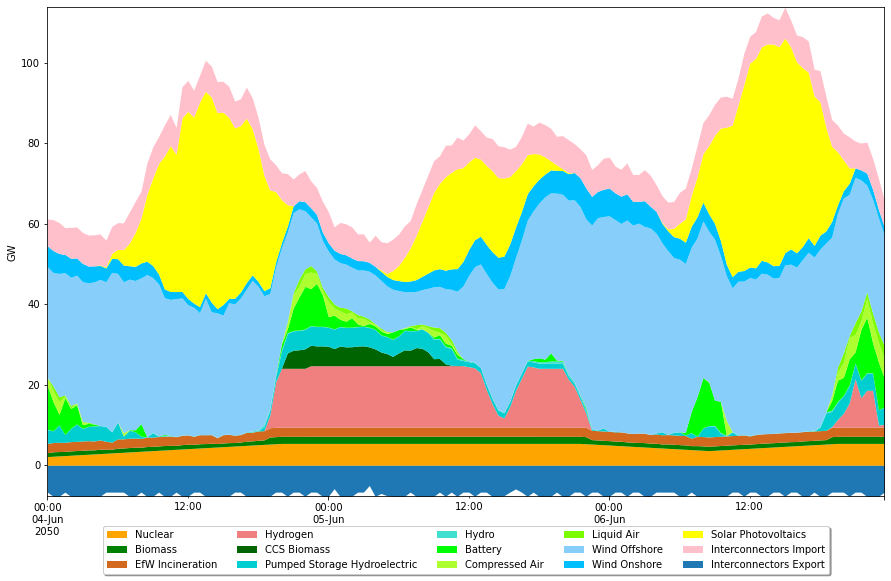

In [16]:
cols = ["Nuclear", 'Shoreline Wave', 'Biomass',
        'EfW Incineration', "Oil", "Natural Gas",
        'Hydrogen', 'CCS Gas', 'CCS Biomass',
        "Pumped Storage Hydroelectric", 'Hydro',
        'Battery', 'Compressed Air', 'Liquid Air',
        "Wind Offshore", 'Wind Onshore', 'Solar Photovoltaics',
        'Interconnectors Import', 'Unmet Load'
        ]

p_by_carrier = p_by_carrier[cols]

p_by_carrier.drop(
    (p_by_carrier.max()[p_by_carrier.max() < 50.0]).index,
    axis=1, inplace=True)


colors = {"Coal": "grey",
          "Diesel/Gas oil": "black",
          "Diesel/gas Diesel/Gas oil": "black",
          'Oil': 'black',
          'Unmet Load': 'black',
          'Anaerobic Digestion': 'green',
          'EfW Incineration': 'chocolate',
          'Sewage Sludge Digestion': 'green',
          'Landfill Gas': 'green',
          'Biomass (dedicated)': 'green',
          'Biomass (co-firing)': 'green',
          'Biomass': 'green',
          'CCS Biomass': 'darkgreen',
          'Interconnectors Import': 'pink',
          "Sour gas": "lightcoral",
          "Natural Gas": "lightcoral",
          'CCS Gas': "lightcoral",
          'Hydrogen': "lightcoral",
          "Nuclear": "orange",
          'Shoreline Wave': 'aqua',
          'Tidal Barrage and Tidal Stream': 'aqua',
          'Hydro': "turquoise",
          "Large Hydro": "turquoise",
          "Small Hydro": "turquoise",
          "Pumped Storage Hydroelectric": "darkturquoise",
          'Battery': 'lime',
          'Compressed Air': 'greenyellow',
          'Liquid Air': 'lawngreen',
          "Wind Offshore": "lightskyblue",
          'Wind Onshore': 'deepskyblue',
          'Solar Photovoltaics': 'yellow'}

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
(p_by_carrier / 1e3).plot(
    kind="area", ax=ax, linewidth=0,
    color=[colors[col] for col in p_by_carrier.columns])

# stacked area plot of negative values, prepend column names with '_' such that they don't appear in the legend
(interconnector_export / 1e3).plot.area(ax=ax, stacked=True, linewidth=0.)
# rescale the y axis
ax.set_ylim([(interconnector_export / 1e3).sum(axis=1).min(), (p_by_carrier / 1e3).sum(axis=1).max()])

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

ax.set_ylabel("GW")

ax.set_xlabel("")

Graph the pumped hydro dispatch and state of charge...

Text(0.5, 0, '')

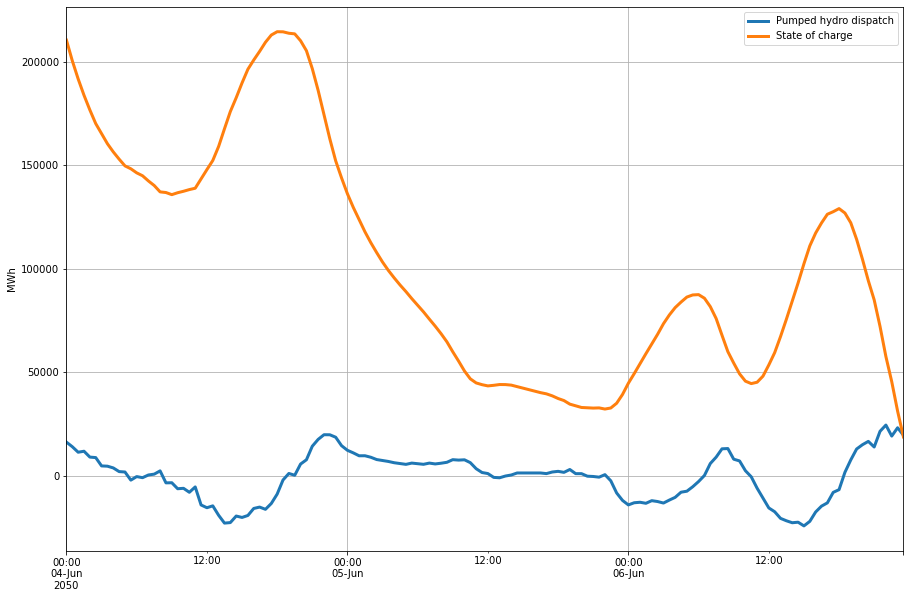

In [17]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)

p_storage = network.storage_units_t.p.sum(axis=1)
state_of_charge = network.storage_units_t.state_of_charge.sum(axis=1)
p_storage.plot(label="Pumped hydro dispatch", ax=ax, linewidth=3)
state_of_charge.plot(label="State of charge", ax=ax, linewidth=3)

ax.legend()
ax.grid()
ax.set_ylabel("MWh")
ax.set_xlabel("")

Look at the line loading stats and graph...

In [18]:
now = network.snapshots[139]

print("With the linear load flow, there is the following per unit loading:")
loading = network.lines_t.p0.loc[now] / network.lines.s_nom
loading.describe()

With the linear load flow, there is the following per unit loading:


count    99.000000
mean      0.377242
std       1.051264
min      -1.719536
25%      -0.213412
50%       0.214607
75%       0.538367
max       4.000000
dtype: float64

(<matplotlib.collections.PatchCollection at 0x2749e7f4970>,
 <matplotlib.collections.LineCollection at 0x2749e6d12b0>)

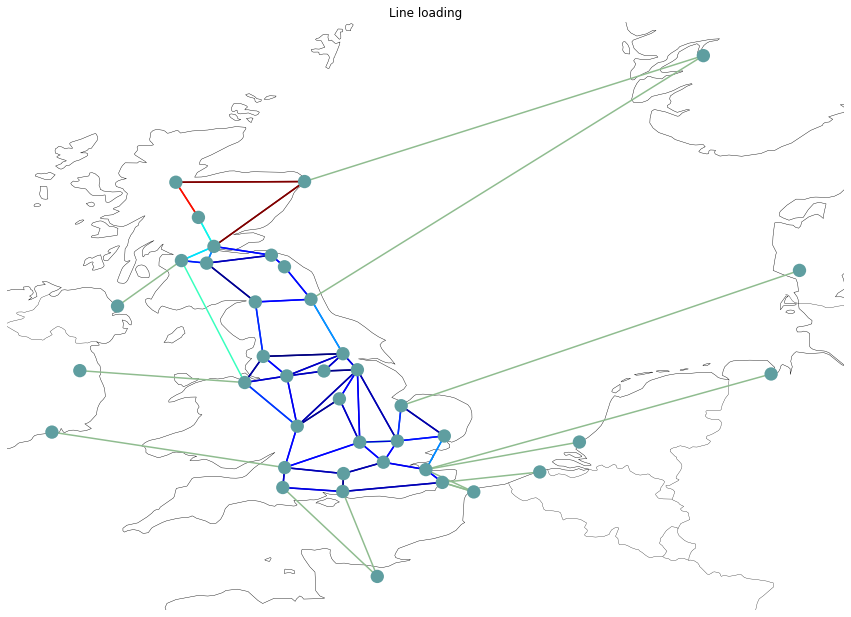

In [19]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})
fig.set_size_inches(15, 17)

network.plot(ax=ax, line_colors=abs(loading), line_cmap=plt.cm.jet, title="Line loading")

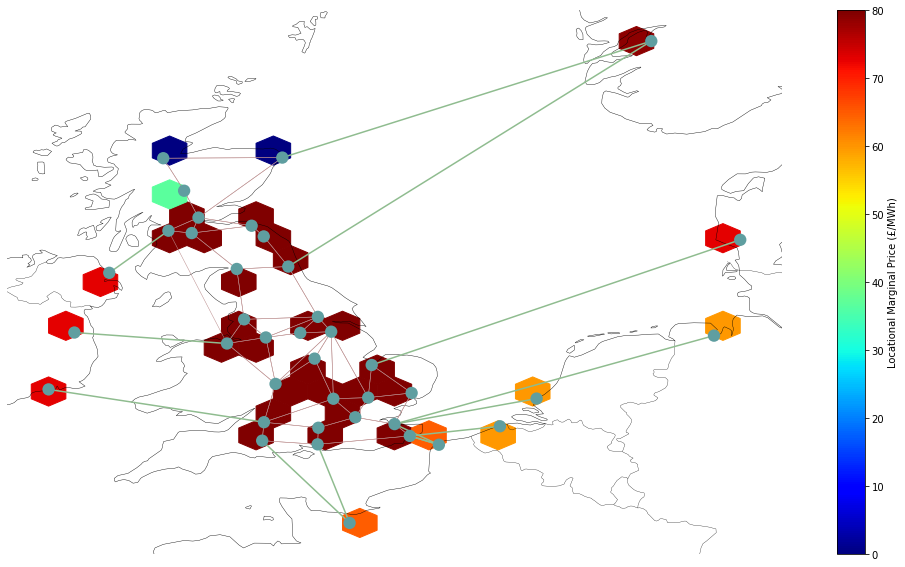

In [20]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})
fig.set_size_inches(20, 10)

network.plot(ax=ax, line_widths=pd.Series(0.5, network.lines.index))
plt.hexbin(network.buses.x, network.buses.y,
           gridsize=20,
           C=network.buses_t.marginal_price.loc[now],
           cmap=plt.cm.jet)

# for some reason the colorbar only works with graphs plt.plot
# and must be attached plt.colorbar

cb = plt.colorbar()
cb.set_label('Locational Marginal Price (£/MWh)')

In [21]:
network.buses_t.marginal_price

name,Beauly,Peterhead,Errochty,Denny/Bonnybridge,Neilston,Strathaven,Torness,Eccles,Harker,Stella West,...,Netherlands,Belgium,France1,France2,Ireland,N. Ireland,Denmark,Germany,Ireland2,Norway
snapshot,,,,,,,,,,,,,,,,,,,,,
2050-06-04 00:00:00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-20.0,-20.0,-15.0,-15.0,-7.0,-7.0,-7.0,-20.0,-7.0,-1.0
2050-06-04 00:30:00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-20.0,-20.0,-15.0,-15.0,-7.0,-7.0,-7.0,-20.0,-7.0,-1.0
2050-06-04 01:00:00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-20.0,-20.0,-15.0,-15.0,-7.0,-7.0,-7.0,-20.0,-7.0,-1.0
2050-06-04 01:30:00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-20.0,-20.0,-15.0,-15.0,-7.0,-7.0,-7.0,-20.0,-7.0,-1.0
2050-06-04 02:00:00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-20.0,-20.0,-15.0,-15.0,-7.0,-7.0,-7.0,-20.0,-7.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2050-06-06 21:30:00,0.0,0.0,36.590789,80.0,80.0,80.0,80.0,80.0,80.0,80.0,...,60.0,60.0,65.0,65.0,73.0,73.0,73.0,60.0,73.0,79.0
2050-06-06 22:00:00,0.0,0.0,36.590789,80.0,80.0,80.0,80.0,80.0,80.0,80.0,...,60.0,60.0,65.0,65.0,73.0,73.0,73.0,60.0,73.0,79.0
2050-06-06 22:30:00,0.0,0.0,36.590789,80.0,80.0,80.0,80.0,80.0,80.0,80.0,...,60.0,60.0,65.0,65.0,73.0,73.0,73.0,60.0,73.0,79.0


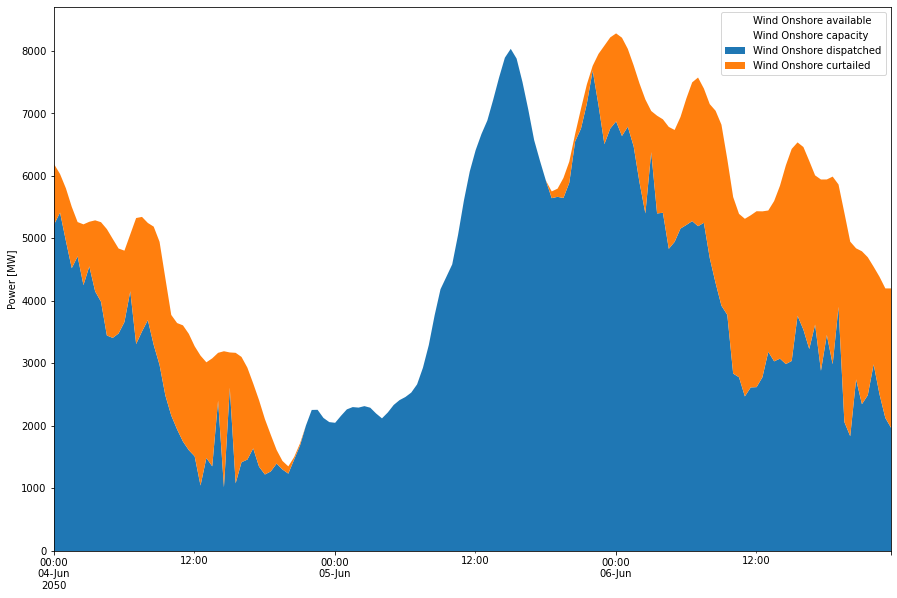

In [22]:
carrier = "Wind Onshore"

capacity = network.generators.groupby("carrier").sum().at[carrier, "p_nom"]
p_available = network.generators_t.p_max_pu.multiply(network.generators["p_nom"])
p_available_by_carrier = p_available.groupby(network.generators.carrier, axis=1).sum()
p_curtailed_by_carrier = p_available_by_carrier - p_by_carrier
p_df = pd.DataFrame({carrier + " available": p_available_by_carrier[carrier],
                     carrier + " dispatched": p_by_carrier[carrier],
                     carrier + " curtailed": p_curtailed_by_carrier[carrier]})

p_df[carrier + " capacity"] = capacity
p_df["Wind Onshore curtailed"][p_df["Wind Onshore curtailed"] < 0.] = 0.
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
p_df[[carrier + " dispatched", carrier + " curtailed"]].plot(kind="area", ax=ax, linewidth=0)
p_df[[carrier + " available", carrier + " capacity"]].plot(ax=ax, linewidth=0)

ax.set_xlabel("")
ax.set_ylabel("Power [MW]")
ax.legend()